## Introduction

This notebook is the result of my final project for my Business Analytics Course.

<br>_The Project_</br>
Using consumer complaint data from the Consumer Financial Protection Bureau (CFBA), build a machine learning model to help banks identify which consumer complaints will result in a dispute and to minimize the cost spent by the bank to resolve it.

<br>_Data Source_</br>
* Data can be downloaded here: https://www.consumerfinance.gov/data-research/consumer-complaints/
* The data used in this notebook was filtered to only include data from the five banks generally considered to be the five largest banks in the US. Namely, Bank of America, National Association, Wells Fargo & Company, JPMorgan Chase & Co., Citibank, U.S. Bancorp.
* The data is limited from 2012-March 2017 because the CFPB stopped collecting data for customer disputes in April 2017.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics

## Exploratory Data Analysis

In [ ]:
# import data
df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/complaints_25Nov21.csv'))
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,NaN,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,NaN,NaN,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,NaN,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22406,Servicemember,NaN,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2013-05-31,Closed with explanation,Yes,No,418647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,2015-05-24,Debt collection,Credit card,Taking/threatening an illegal action,Sued w/o proper notification of suit,NaN,NaN,JPMORGAN CHASE & CO.,FL,33133,NaN,Consent not provided,Web,2015-05-24,Closed with explanation,Yes,No,1390395
207256,2012-01-10,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,JPMORGAN CHASE & CO.,NY,10312,NaN,NaN,Referral,2012-01-11,Closed without relief,Yes,Yes,12192
207257,2012-07-17,Student loan,Non-federal student loan,Repaying your loan,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",NH,032XX,NaN,NaN,Web,2012-07-18,Closed with explanation,Yes,No,118351
207258,2016-09-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,Near the end of XXXX 2016 I opened a Citigold ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,900XX,NaN,Consent provided,Web,2016-09-29,Closed with non-monetary relief,Yes,No,2138969


In [ ]:
# Find the responses we have for the target variable
df['Consumer disputed?'].value_counts()

No     162357
Yes     44903
Name: Consumer disputed?, dtype: int64

In [ ]:
# Null-values?
df.isnull().sum()

Date received                        0
Product                              0
Sub-product                      43015
Issue                                0
Sub-issue                       196913
Consumer complaint narrative    177869
Company public response         148802
Company                              0
State                             2194
ZIP code                          9286
Tags                            178995
Consumer consent provided?      155947
Submitted via                        0
Date sent to company                 0
Company response to consumer         0
Timely response?                     0
Consumer disputed?                   0
Complaint ID                         0
dtype: int64

**Initial thoughts**
With 207260 rows of data, we have a huge dataset. While this is very exciting I also need to be very selective with how I preprocess the data, which features I select or feature engineer into my model given that I'm just working with my personal computer.

Columns:
* Date received - drop
* Products - keep
* Sub-product - unsure
* Issue - drop (issues are related to products, let's avoid redundancy)
* Sub-issue - drop (high cardinality, the big picture is likely captured by Products)
* Consumer complaint narrative - keep for FE (given the size of our dataset, closely analyzing the narrative will be computationally very costly but let's find another way to use this data)
* Company public response - keep
* Company - drop (the assignment specified building a model for the five biggest banks, not for any individual bank; the dataset includes only complaints from these five banks)
* State - unsure (Again, this this column of categorial data has high cardinality but includes nonetheless probably useful data)
* ZIP code - drop
* Tags - keep for FE
* Consumer consent provided? - drop
* Submitted via - keep for FE
* Data sent to company - drop
* Company response to consumer - keep for FE
* Timely response? - drop
* Consumer disputed? - Target variable
* Complaint ID - drop


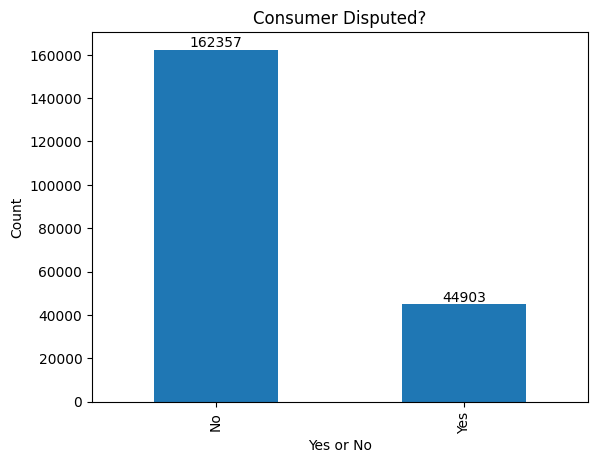

In [ ]:
# Split between yes and no
import matplotlib.pyplot as plt

df['Consumer disputed?'].value_counts().plot(kind='bar')

for i, (value, count) in enumerate(df['Consumer disputed?'].value_counts().items()):
  plt.annotate(str(count), xy=(i, count), ha='center', va='bottom')

plt.title('Consumer Disputed?')
plt.xlabel('Yes or No')
plt.ylabel('Count')
plt.show()

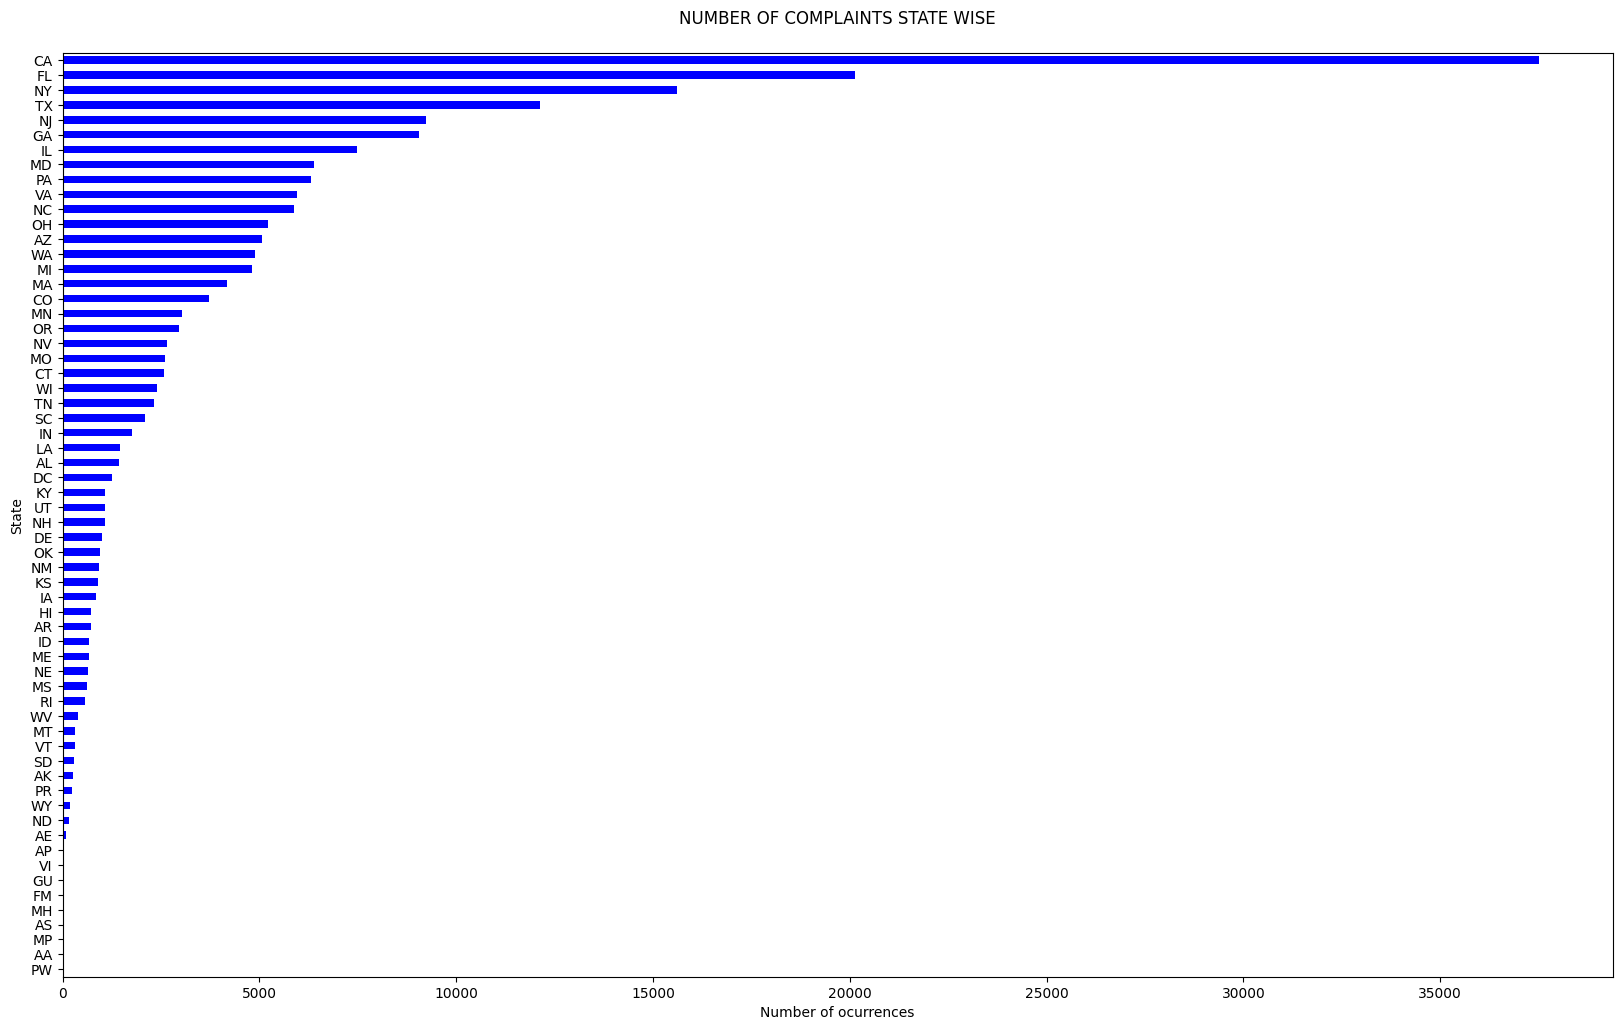

In [ ]:
fig = plt.figure(figsize=(20,12))
df.groupby(['State'])['Complaint ID'].count().sort_values().plot.barh(
    ylim=0, color='blue', title= 'NUMBER OF COMPLAINTS STATE WISE\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

California State has the most number of complaints

In [ ]:
# function to see the how frequently each product gets dipsuted
def get_percent(prod):
    prod_yes = len(df.loc[(df['Product']==prod) & (df['Consumer disputed?'] == 'Yes')])
    return float(prod_yes/len(df.loc[df['Product']==prod]))

In [ ]:
product_key = df['Product'].unique().tolist()
values = [get_percent(prod) for prod in product_key]
product_dict = dict(zip(product_key, values))

sorted(product_dict.items(), key=lambda x: x[1], reverse=False)

[('Payday loan', 0.1566265060240964),
 ('Credit reporting', 0.16734143049932523),
 ('Prepaid card', 0.1700787401574803),
 ('Debt collection', 0.18916168426408853),
 ('Bank account or service', 0.19233529174328384),
 ('Consumer Loan', 0.21405228758169934),
 ('Credit card', 0.21689459837406083),
 ('Student loan', 0.22365666434054432),
 ('Mortgage', 0.229720692368214),
 ('Other financial service', 0.23706896551724138),
 ('Money transfers', 0.24165707710011508)]

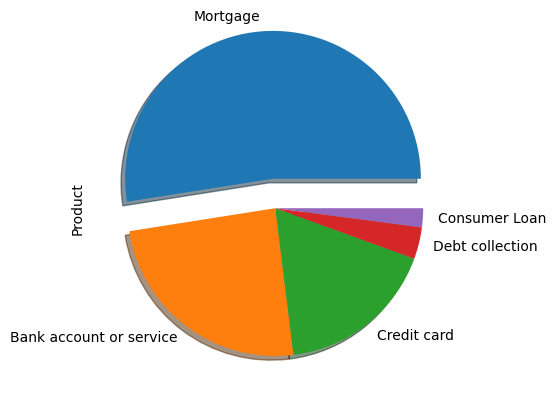

In [ ]:
# Top 5 Products
df[df['State'] == 'CA']['Product'].value_counts().head(5).plot.pie(explode=[0.2,0,0,0,0],shadow=True)
# Unsquish the pie.
import matplotlib.pyplot as plt
plt.gca().set_aspect('equal')

When I was experimenting with developing a new feature using the 'Product' data I found that encoding by the % of the complaints that were disputed by product category performed better than an ordinal ranking of this frequency. Consequently, I included the former in my model.

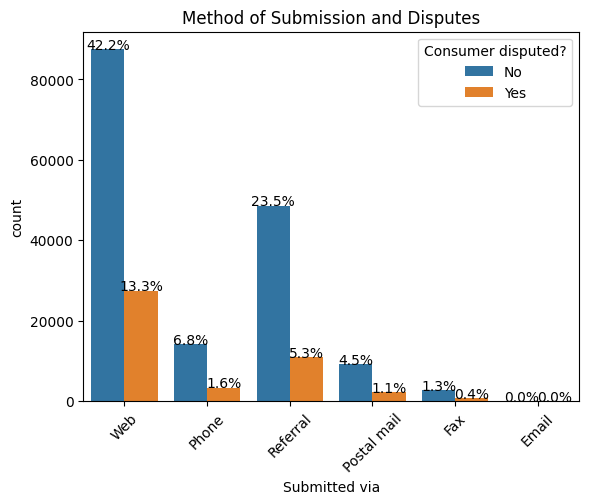

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.countplot(x='Submitted via', data=df, hue='Consumer disputed?')

# Calculate and display percentage values
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:.1f}%'.format((height/total)*100),
            ha="center")

plt.xticks(rotation=45)
ax.set_title('Method of Submission and Disputes')
plt.show()

Visulaization of disputes with respect to the way of submission

In [ ]:
# function to see the distrubution how the dipsuted complaints were submitted
def get_percent_s(prod):
    prod_yes = len(df.loc[(df['Submitted via']==prod) & (df['Consumer disputed?'] == 'Yes')])
    return float(prod_yes/len(df.loc[df['Submitted via']==prod]))

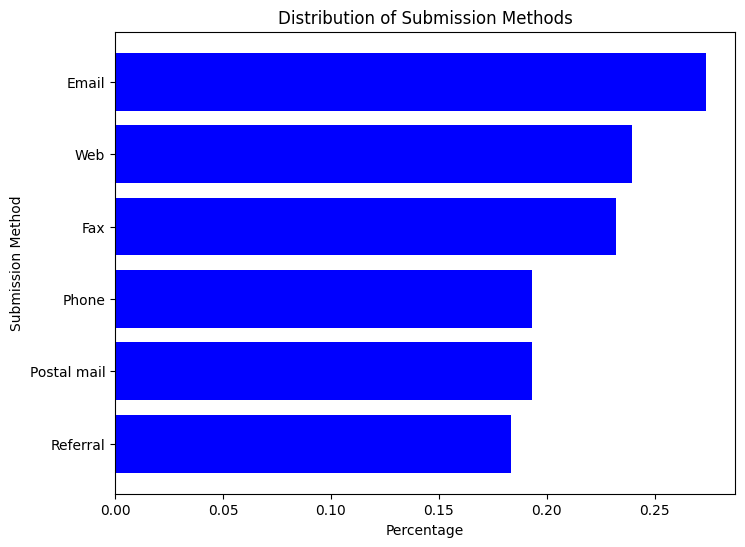

In [ ]:
# submission_key = df['Submitted via'].unique().tolist()
# values = [get_percent_s(s) for s in submission_key]
# submission_dict = dict(zip(submission_key, values))

# sorted(submission_dict.items(), key=lambda x: x[1], reverse=False)
submission_key = df['Submitted via'].unique().tolist()
values = [get_percent_s(s) for s in submission_key]
submission_dict = dict(zip(submission_key, values))

# Sort the dictionary in ascending order of percentage
sorted_dict = dict(sorted(submission_dict.items(), key=lambda x: x[1], reverse=False))

# Create the horizontal bar chart
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(list(sorted_dict.keys()), list(sorted_dict.values()), color='blue')
ax.set_xlabel('Percentage')
ax.set_ylabel('Submission Method')
ax.set_title('Distribution of Submission Methods')
plt.show()

Again, while modeling I found that encoding the 'Submitted via' data by the % of the complaints that were disputed by submission method performed better than an ordinal ranking of the frequency.

In [ ]:
# Sub issue
len(set(df['Sub-issue'].values.tolist()))

58

Very high cardinality - dropping this feature.

In [ ]:
# Tags
tags = list(set(df['Tags'].values.tolist()))
tags

['Older American, Servicemember', 'Older American', nan, 'Servicemember']

In [ ]:
# Consumer Complaint Narrative
ccn = df['Consumer complaint narrative'].values.tolist()

In [ ]:
# what percentage of ccns disputed?
ccn_yes = len(df.loc[(df['Consumer complaint narrative'].notnull()) & (df['Consumer disputed?'] == 'Yes')])
ccn_yes/len(df.loc[(df['Consumer complaint narrative'].notnull())])

0.23939301146609507

The majority of the complaints were not disputed. To adequately train the model, we must try to balance the classes.

In [ ]:
# function to get word count complaint
def get_wc(complaint):
    print(complaint)
    return len(complaint)

In [ ]:
word_count = df['Consumer complaint narrative'].str.split().str.len()
df['CCN wordcount'] = word_count

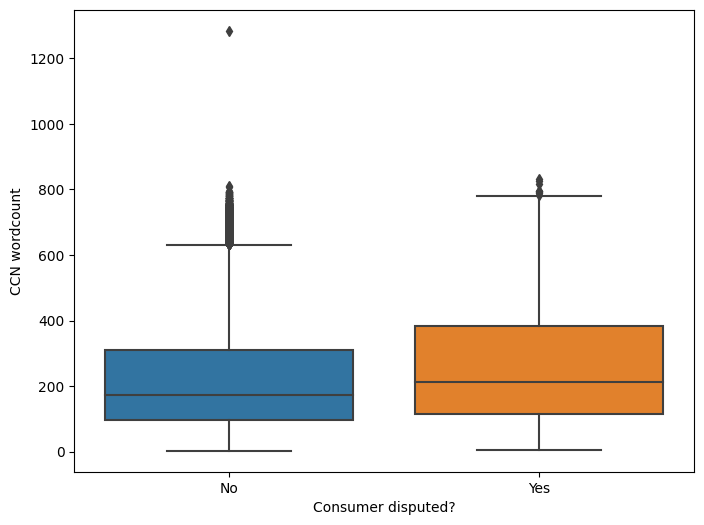

In [ ]:
# Create the boxplots
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(y='CCN wordcount', x='Consumer disputed?', data=df);
# To keep in mind, when input data contains NaN, it will automaically be filled with 0

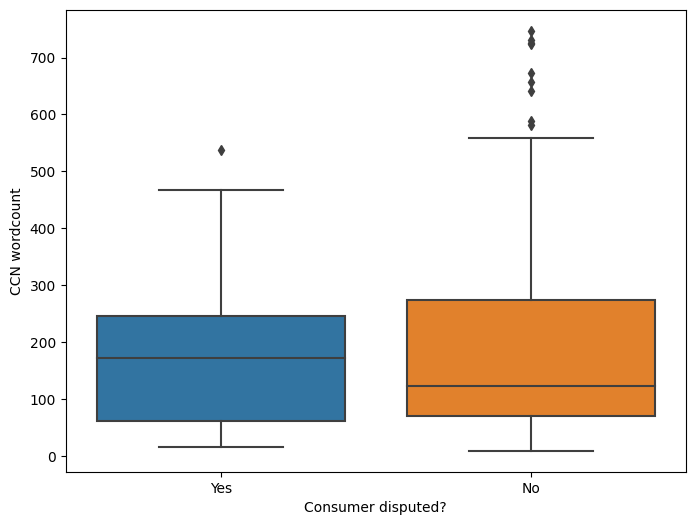

In [ ]:
# Compare with previous plot, this time don't fill in 0s for NaN
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(y='CCN wordcount', x='Consumer disputed?', data=df.dropna());

Generally, complaints with higher word counts are less likely to get disputed.
Earlier I considered grouping the word count but now I'm thinking that our model won't have alot of numerical data and that would be difficult for humans to choose a good cut-off for groups - leave 'CNN' Wordcount as its own feature but normalize it to improve performance in the model.

In [ ]:
# what percentage of older american and service member disputed?
tag_yes = len(df.loc[(df['Tags'].isnull()) & (df['Consumer disputed?'] == 'Yes')])
tag_yes/len(df.loc[(df['Tags'].isnull())])

0.21392217659711166

That's also not unsignficant - it would be simple enough to create a column to flag whether or not the customer was tagged as an older american or a service member.

## Feature Engineering

In the previous section, I noted a couple of features I wanted to develop. Another feature that improved the performance of my model was one that takes into account the relationship between whether or not the banks provided some relief in response to the complaint and the ranking of the product in terms of disputed complaints.

In [ ]:
df['Consumer disputed?'] = df['Consumer disputed?'].astype('category')

In [ ]:
X = df[[ 'Product', 'Issue',
        'Company public response', 'Company',
       'State',  'Tags',
       'Submitted via',  'Company response to consumer',
       'Timely response?','Consumer complaint narrative']]

In [ ]:
# Check how many values are missing in each column

X.isna().sum()

Product                              0
Issue                                0
Company public response         148802
Company                              0
State                             2194
Tags                            178995
Submitted via                        0
Company response to consumer         0
Timely response?                     0
Consumer complaint narrative    177869
dtype: int64

In [ ]:
X = X.fillna('missing')
X.dropna().shape

(207260, 10)

Performing Sntiment Analysis to replace each and every complaint with their respective sentiment(positive, negative and neutral)

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# create an instance of the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()


# define a function to get the sentiment score for a given sentence
def get_sentiment_score(sentence):
    score = analyzer.polarity_scores(str(sentence))
    return score['compound']

# apply the get_sentiment_score() function to the 'complaint' column
X['sentiment_score'] = X['Consumer complaint narrative'].apply(get_sentiment_score)

# define a function to map the sentiment score to a sentiment label
def get_sentiment_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# apply the get_sentiment_label() function to the 'sentiment_score' column
X['sentiment'] = X['sentiment_score'].apply(get_sentiment_label)

# print the resulting DataFrame
print(X.head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                   Product                                     Issue  \
0          Money transfers                  Other transaction issues   
1  Bank account or service   Account opening, closing, or management   
2  Bank account or service  Making/receiving payments, sending money   
3                 Mortgage  Application, originator, mortgage broker   
4                 Mortgage  Loan modification,collection,foreclosure   

                             Company public response  \
0  Company has responded to the consumer and the ...   
1   Company chooses not to provide a public response   
2   Company chooses not to provide a public response   
3                                            missing   
4                                            missing   

                                 Company    State            Tags  \
0                         CITIBANK, N.A.  missing         missing   
1                         CITIBANK, N.A.       PA  Older American   
2                      

In [ ]:
# Next, we convert all the X observations into numbers
X = X[[ 'Product', 'Issue',
        'Company public response', 'Company',
       'State',  'Tags',
       'Submitted via',  'Company response to consumer',
       'Timely response?','sentiment']]
X = pd.get_dummies(X)

In [ ]:
# Let us see what X looks like

print('X has the shape ',X.shape)

X

X has the shape  (207260, 203)


,Product_Bank account or service,Product_Consumer Loan,Product_Credit card,Product_Credit reporting,Product_Debt collection,Product_Money transfers,Product_Mortgage,Product_Other financial service,Product_Payday loan,Product_Prepaid card,...,Company response to consumer_Closed with monetary relief,Company response to consumer_Closed with non-monetary relief,Company response to consumer_Closed with relief,Company response to consumer_Closed without relief,Company response to consumer_Untimely response,Timely response?_No,Timely response?_Yes,sentiment_negative,sentiment_neutral,sentiment_positive
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
207256,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,1,0,0
207257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
207258,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [ ]:
y = df['Consumer disputed?']

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(df['Consumer disputed?'])
print(le.classes_)
print(le.inverse_transform(list(set(y))))
labels = dict(zip(list(set(y)), le.inverse_transform(list(set(y)))))
print("\nLabel mapping is:", labels)

['No' 'Yes']
['No' 'Yes']

Label mapping is: {0: 'No', 1: 'Yes'}


In [ ]:
# Let us now look at what y looks like
y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Let us do a value_counts() to check how many of each category.  But we have to convert to a Pandas dataframe first.
print(pd.DataFrame(y).value_counts(), '\n')
print(pd.DataFrame(y).value_counts(normalize=True))

0    162357
1     44903
dtype: int64 

0    0.783349
1    0.216651
dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# We check the shape of our X and y

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(165808, 203)
(165808,)
(41452, 203)
(41452,)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train, y_train = undersampler.fit_resample(X, y)

In [ ]:
# Let us check if the dataset is balanced
# just checking that the '1' category is exactly 50% of the training set

y_train.sum()/len(y_train)

0.5

In [ ]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(207260, 203)
(89806, 203)
(41452, 203)


## Modelling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

              precision    recall  f1-score   support

           0       0.91      0.59      0.72     32446
           1       0.35      0.80      0.49      9006

    accuracy                           0.63     41452
   macro avg       0.63      0.70      0.60     41452
weighted avg       0.79      0.63      0.67     41452



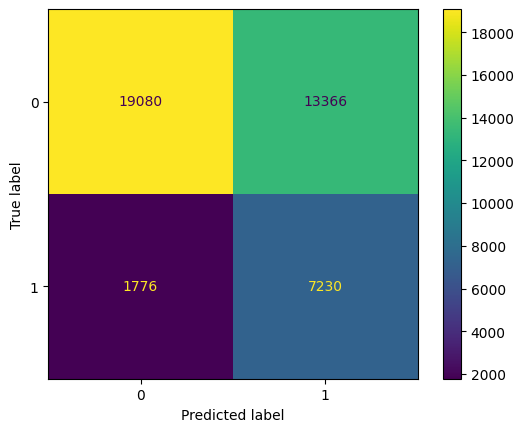

In [ ]:
# Check the classification report and the confusion matrix


cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();
report = classification_report(y_test, pred)
print(report)

In [ ]:
# Let us look at label mappings to check what 0 and 1 mean
# Looks like "0" means NoDispute, and "1" means "Dispute"

print("Label mapping is:", labels)

Label mapping is: {0: 'No', 1: 'Yes'}


In [ ]:
# Cost when model predicts dispute and actually disputed
True_NoDispute_Cost = 100 * cm[0, 0]

# Cost when model predicts dispute and no actual dispute
False_Dispute_Cost = 190 * cm[0,1]

# Cost when model predicts NoDispute and actually disputed
False_NoDispute_Cost = 600 * cm[1,0]

# Cost when model predicts NoDispute correctly
True_Dispute_Cost = 190 * cm[1,1]


In [ ]:
Total_cost = True_NoDispute_Cost + False_Dispute_Cost + False_NoDispute_Cost + True_Dispute_Cost
Total_cost

6886840

## Performance and Threshold Analysis



Confusion Matrix : 
 [[ 2866 29580]
 [    3  9003]]
Test accuracy =  0.28633117823024223
              precision    recall  f1-score   support

           0       1.00      0.09      0.16     32446
           1       0.23      1.00      0.38      9006

    accuracy                           0.29     41452
   macro avg       0.62      0.54      0.27     41452
weighted avg       0.83      0.29      0.21     41452



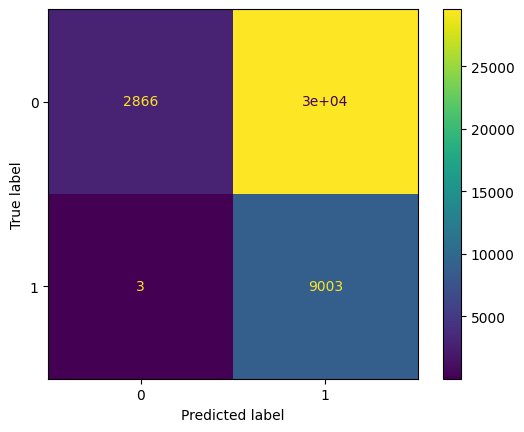

In [ ]:
# Set threshold for identifying class 1
threshold = 0.1

# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = rf.predict_proba(X_test)

# We drop the probabilities for class 0, and keep just the second column
pred_prob = pred_prob[:,1]

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, pred))
print(classification_report(y_true = y_test, y_pred = pred))

So we see that recall has gone up to 90% from a lower number earlier.

In [ ]:
pred

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
# Cost when model predicts dispute and actually disputed
True_NoDispute_Cost = 100 * cm[0, 0]

# Cost when model predicts dispute and no actual dispute
False_Dispute_Cost = 190 * cm[0,1]

# Cost when model predicts NoDispute and actually disputed
False_NoDispute_Cost = 600 * cm[1,0]

# Cost when model predicts NoDispute correctly
True_Dispute_Cost = 190 * cm[1,1]

In [ ]:
Total_cost = True_NoDispute_Cost + False_Dispute_Cost + False_NoDispute_Cost + True_Dispute_Cost
Total_cost

7619170

100%|██████████| 100/100 [04:56<00:00,  2.96s/it]


<Axes: xlabel='threshold', ylabel='Total_cost'>

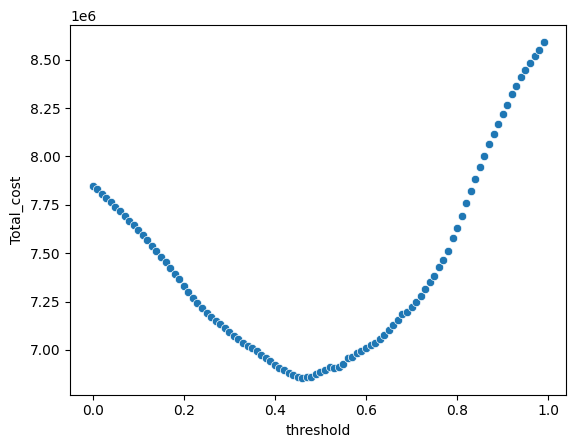

In [ ]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score

# %%time
# Set threshold for identifying class 1
threshold = 0.0001
appended_data = []

for threshold in tqdm(np.arange(0,1,.01)):
    # Create predictions.  Note that predictions give us probabilities, not classes!
    pred_prob = rf.predict_proba(X_test)

    # We drop the probabilities for class 0, and keep just the second column
    pred_prob = pred_prob[:,1]

    # Convert probabilities to 1s and 0s based on threshold
    pred = (pred_prob>threshold).astype(int)

    # confusion matrix
    cm = confusion_matrix(y_test, pred)

    # accuracy score of the model
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred,zero_division=0)
    recall = recall_score(y_test, pred)

    # Cost when model predicts dispute and actually disputed
    True_NoDispute_Cost = 100 * cm[0, 0]

    # Cost when model predicts dispute and no actual dispute
    False_Dispute_Cost = 190 * cm[0,1]

    # Cost when model predicts NoDispute and actually disputed
    False_NoDispute_Cost = 600 * cm[1,0]

    # Cost when model predicts NoDispute correctly
    True_Dispute_Cost = 190 * cm[1,1]

    Total_cost = True_NoDispute_Cost + False_Dispute_Cost + False_NoDispute_Cost + True_Dispute_Cost
    Total_cost

    data = pd.DataFrame({'threshold':[threshold], 'accuracy': [accuracy],
                         'precision':[precision], 'recall':[recall],
                         'True_NoDispute_Cost':[True_NoDispute_Cost],
                         'False_Dispute_Cost':[False_Dispute_Cost],
                         'False_NoDispute_Cost':[False_NoDispute_Cost],
                         'True_Dispute_Cost':[True_Dispute_Cost],
                         'Total_cost':[Total_cost]})
    appended_data.append(data)



appended_data = pd.concat(appended_data)

appended_data.reset_index()

# appended_data.to_excel('temp.xlsx')
sns.scatterplot(data = appended_data, y = 'Total_cost', x = 'threshold')

In [ ]:
# At this point I can review the dataframe appended_data to find out the best threshold for minimizing cost
# Or I can do a simple query to list only the row that has the minumum cost by asking for
# appended_data[appended_data.Total_cost == appended_data.Total_cost.min()]
# I add some transpose and rounding to make it easier to read.

print(round(appended_data[appended_data.Total_cost == appended_data.Total_cost.min()].transpose(),3))

                                0
threshold                   0.460
accuracy                    0.586
precision                   0.330
recall                      0.877
True_NoDispute_Cost   1638500.000
False_Dispute_Cost    3051590.000
False_NoDispute_Cost   664200.000
True_Dispute_Cost     1500810.000
Total_cost            6855100.000


# **So my minimum cost occurs at a threshold of 0.46, and the cost is $6.85 mm.**





AUC and ROC Calculation

In [ ]:
# AUC calculation
from sklearn import metrics
metrics.roc_auc_score(y_test, pred_prob)

0.788124150358903

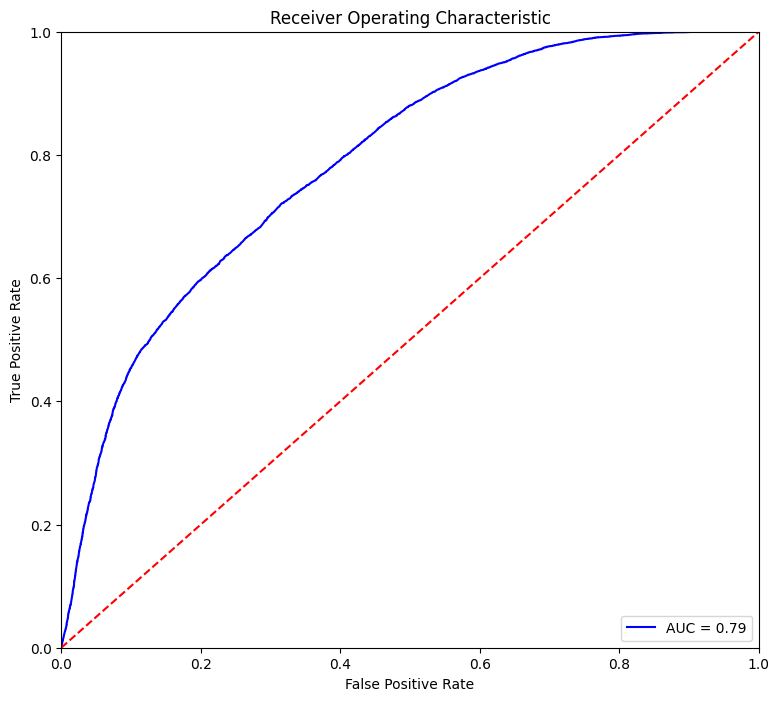

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
pd.DataFrame({'TPR': tpr, 'FPR': fpr, 'Threshold': thresholds}).sort_values(by = ['Threshold']).reset_index(drop=True)

,TPR,FPR,Threshold
0,1.000000,1.000000,0.000000
1,1.000000,0.991031,0.001250
2,1.000000,0.990908,0.001563
3,1.000000,0.990754,0.001667
4,1.000000,0.990692,0.002500
...,...,...,...
11058,0.011215,0.002096,0.998333
11059,0.011104,0.002065,0.998947
11060,0.011104,0.002034,0.999000
11061,0.010882,0.002034,1.000000
